<a href="https://colab.research.google.com/github/Egorundel/CV_task_2/blob/main/gan_hw.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### WGAN

* Модифицируйте код ячеек ниже и реализуйте [Wasserstein GAN](https://arxiv.org/abs/1701.07875) с клиппингом весов. (10 баллов)

* Замените клиппинг весов на [штраф градентов](https://arxiv.org/pdf/1704.00028v3.pdf). (10 баллов)

* Добавьте лейблы в WGAN, тем самым решая задачу [условной генерации](https://arxiv.org/pdf/1411.1784.pdf). (30 баллов)

Добавьте в этот файл анализ полученных результатов с различными графиками обучения и визуализацию генерации. Сравните как работает клиппинг весов и штраф градиентов и попробуйте пронаблюдать какие недостатки имеет модель GAN.

# Импорт библиотек

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

import torchvision
import matplotlib.pyplot as plt
import numpy as np

from torch.autograd import Variable
from torch import autograd

# Конфигурация для настройки

In [2]:
class Config:
    def __init__(self):
        self.mnist_path = None
        self.batch_size = 16
        self.image_chanels = 1
        self.num_workers = 3
        self.num_epochs = 10
        self.noise_shape = 6
        self.noise_size = self.noise_shape**2
        self.print_freq = 500
        self.generator_freq = 5
        self.n_classes = 10

config = Config()

# DataLoader

In [3]:
train = torchvision.datasets.FashionMNIST("fashion_mnist", train=True, transform=torchvision.transforms.ToTensor(), download=True)

In [4]:
dataloader = DataLoader(train, batch_size=config.batch_size, shuffle=True)

In [5]:
len(dataloader)

3750

In [6]:
image, label = next(iter(dataloader))

In [7]:
image.size()

torch.Size([16, 1, 28, 28])

# WGAN с клиппингом весом

## Model GAN

In [8]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()

        # Создание модели генератора
        self.model = nn.Sequential(
            nn.Linear(config.noise_size, 256),
            nn.ReLU(inplace=True),  # Используем inplace=True для экономии памяти
            nn.Linear(256, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        # Прямой проход генератора
        return self.model(x)

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()

        # Создание модели дискриминатора
        self.model = nn.Sequential(
            nn.Linear(28*28, 1024),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 1),
            nn.Sigmoid()  # Используем сигмоиду для получения вероятности
        )

    def forward(self, x):
        # Прямой проход дискриминатора
        return self.model(x)

In [9]:
generator = Generator()
discriminator = Discriminator()

## Optimizer and loss function

In [10]:
# Определение устройства для обучения: GPU, если доступно, иначе CPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Перемещение моделей генератора и дискриминатора на выбранное устройство
generator = generator.to(device)
discriminator = discriminator.to(device)

# Определение параметров обучения
lr = 1e-4  # скорость обучения
betas = (.9, .99)  # параметры для оптимизатора Adam

# Создание оптимизаторов для моделей генератора и дискриминатора
optim_D = optim.Adam(params=discriminator.parameters(), lr=lr)
optim_G = optim.Adam(params=generator.parameters(), lr=lr, betas=betas)

## Optimize the learning

In [11]:
noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size,).to(device))

## GAN learning

Training:   0%|          | 0/120000 [00:00<?, ?it/s]

Epoch 1 of 32, 3750 values per epoch


Training:   3%|▎         | 3750/120000 [00:42<17:31, 110.52it/s, epoch=1, errD=-.919, errG=-.02]

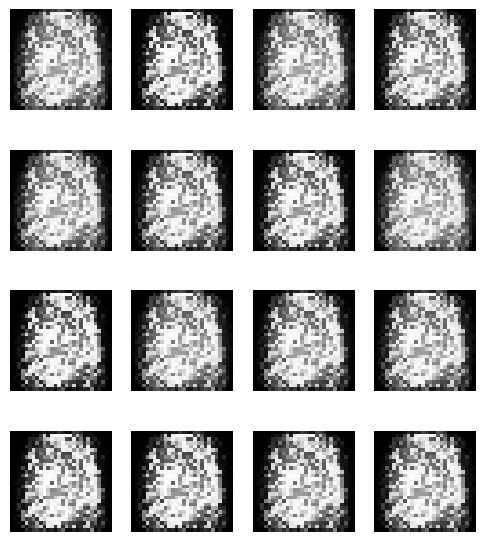

Training:   3%|▎         | 3771/120000 [00:42<37:59, 51.00it/s, epoch=2, errD=-.926, errG=-.0158]

Epoch 2 of 32, 3750 values per epoch


Training:   6%|▋         | 7500/120000 [01:19<17:43, 105.78it/s, epoch=2, errD=-.822, errG=-.042]

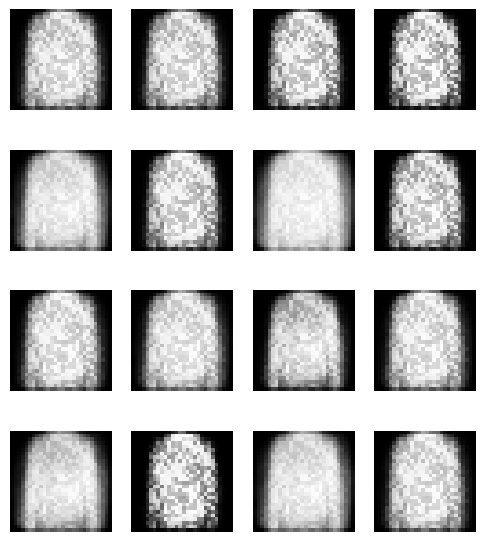

Training:   6%|▋         | 7520/120000 [01:19<37:03, 50.59it/s, epoch=3, errD=-.766, errG=-.0681]

Epoch 3 of 32, 3750 values per epoch


Training:   9%|▉         | 11250/120000 [01:57<20:00, 90.56it/s, epoch=3, errD=-.704, errG=-.0668]

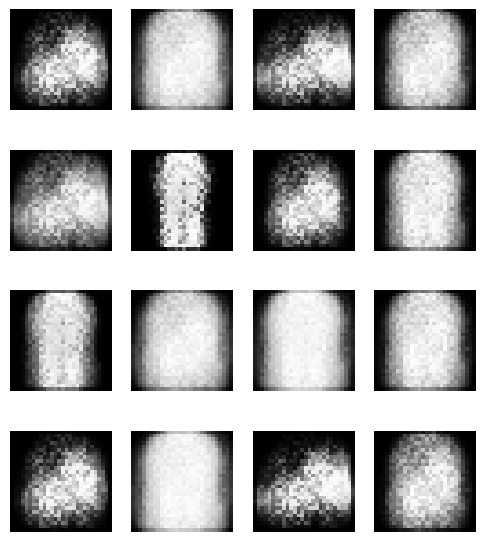

Training:   9%|▉         | 11267/120000 [01:58<50:55, 35.59it/s, epoch=4, errD=-.69, errG=-.108] 

Epoch 4 of 32, 3750 values per epoch


Training:  12%|█▎        | 15000/120000 [02:35<16:54, 103.51it/s, epoch=4, errD=-.657, errG=-.131]

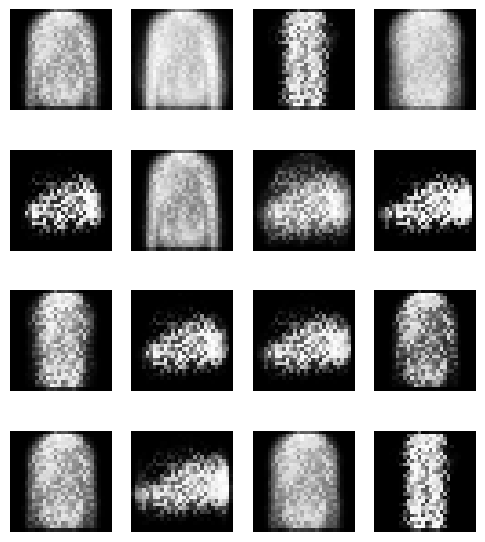

Training:  13%|█▎        | 15020/120000 [02:36<29:56, 58.42it/s, epoch=5, errD=-.653, errG=-.137]

Epoch 5 of 32, 3750 values per epoch


Training:  16%|█▌        | 18750/120000 [03:14<17:25, 96.89it/s, epoch=5, errD=-.592, errG=-.174]

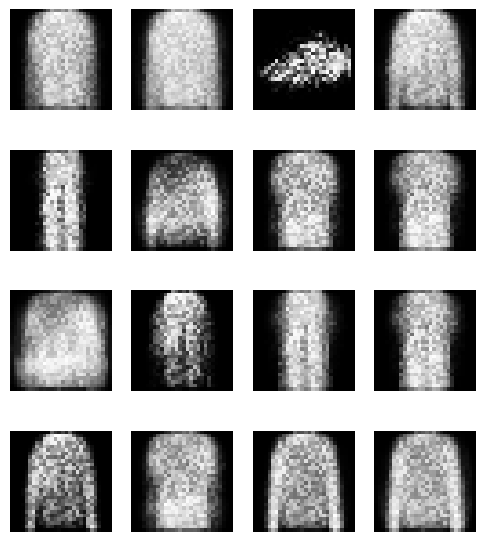

Training:  16%|█▌        | 18770/120000 [03:15<36:44, 45.92it/s, epoch=6, errD=-.604, errG=-.165]

Epoch 6 of 32, 3750 values per epoch


Training:  19%|█▉        | 22500/120000 [03:54<16:19, 99.54it/s, epoch=6, errD=-.568, errG=-.201]

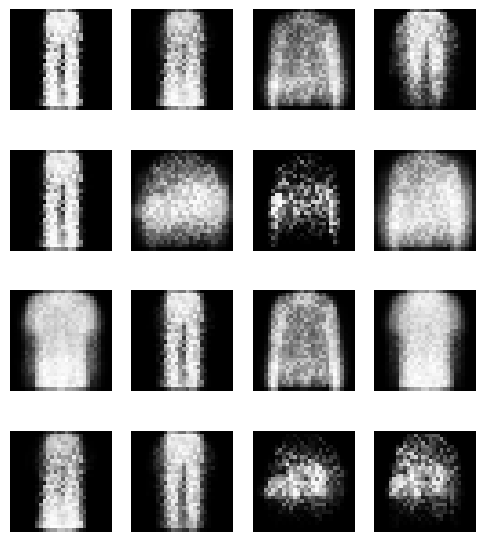

Training:  19%|█▉        | 22519/120000 [03:54<29:16, 55.51it/s, epoch=7, errD=-.395, errG=-.448]

Epoch 7 of 32, 3750 values per epoch


Training:  22%|██▏       | 26250/120000 [04:34<16:55, 92.32it/s, epoch=7, errD=-.465, errG=-.24]

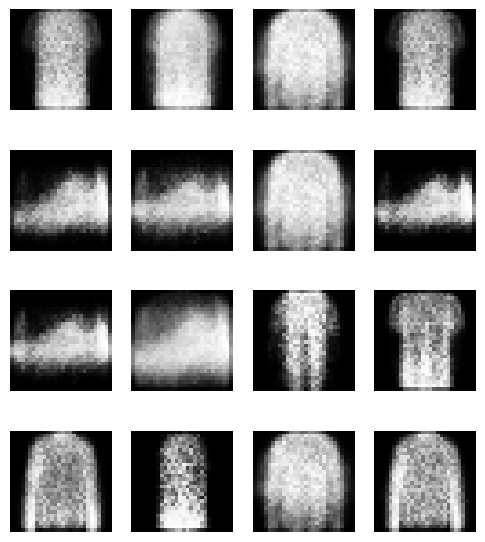

Training:  22%|██▏       | 26269/120000 [04:35<29:46, 52.45it/s, epoch=8, errD=-.426, errG=-.188]

Epoch 8 of 32, 3750 values per epoch


Training:  25%|██▌       | 30000/120000 [05:15<17:43, 84.64it/s, epoch=8, errD=-.428, errG=-.269]

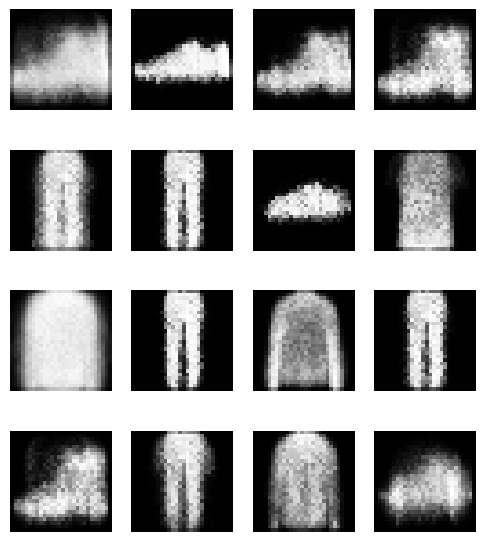

Training:  25%|██▌       | 30018/120000 [05:16<45:34, 32.90it/s, epoch=9, errD=-.401, errG=-.262]

Epoch 9 of 32, 3750 values per epoch


Training:  28%|██▊       | 33750/120000 [05:56<16:26, 87.46it/s, epoch=9, errD=-.424, errG=-.268]

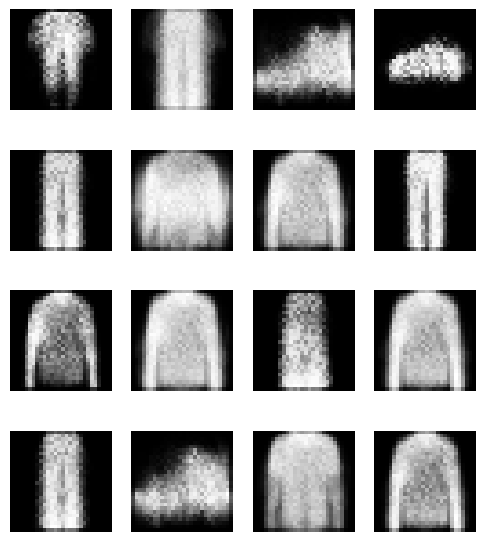

Training:  28%|██▊       | 33767/120000 [05:57<29:05, 49.39it/s, epoch=10, errD=-.403, errG=-.32]

Epoch 10 of 32, 3750 values per epoch


Training:  31%|███▏      | 37500/120000 [06:38<15:46, 87.15it/s, epoch=10, errD=-.379, errG=-.297]

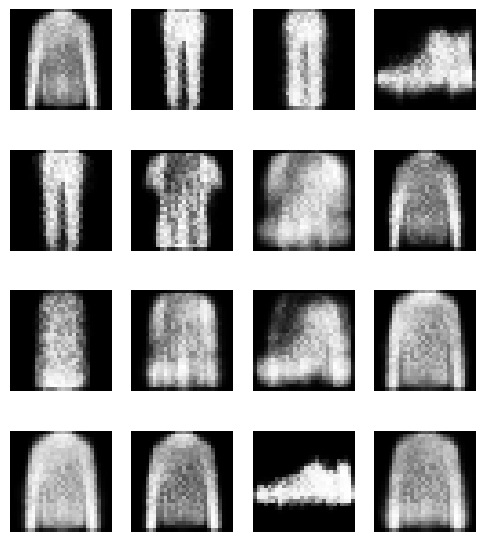

Training:  31%|███▏      | 37518/120000 [06:39<30:07, 45.64it/s, epoch=11, errD=-.353, errG=-.335]

Epoch 11 of 32, 3750 values per epoch


Training:  34%|███▍      | 41250/120000 [07:20<13:50, 94.80it/s, epoch=11, errD=-.336, errG=-.327]

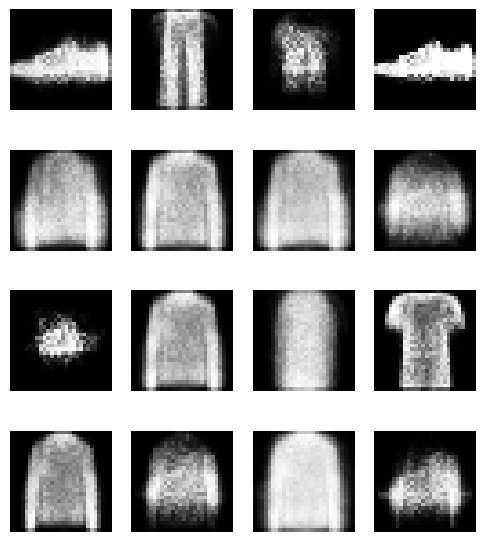

Training:  34%|███▍      | 41265/120000 [07:21<49:43, 26.39it/s, epoch=12, errD=-.348, errG=-.265]

Epoch 12 of 32, 3750 values per epoch


Training:  38%|███▊      | 45000/120000 [08:02<14:24, 86.80it/s, epoch=12, errD=-.299, errG=-.347]

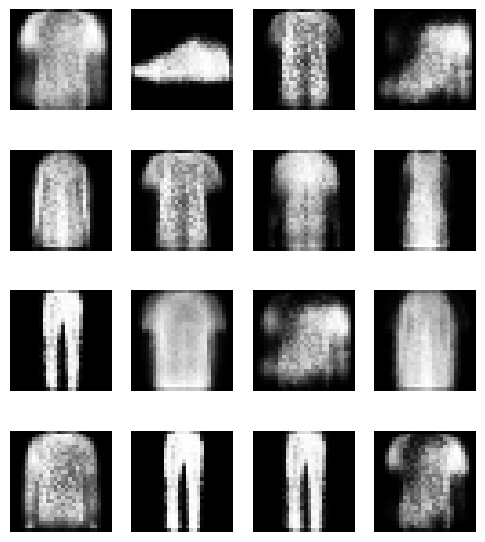

Training:  38%|███▊      | 45017/120000 [08:03<29:48, 41.92it/s, epoch=13, errD=-.302, errG=-.326]

Epoch 13 of 32, 3750 values per epoch


Training:  41%|████      | 48750/120000 [08:44<13:59, 84.83it/s, epoch=13, errD=-.276, errG=-.368]

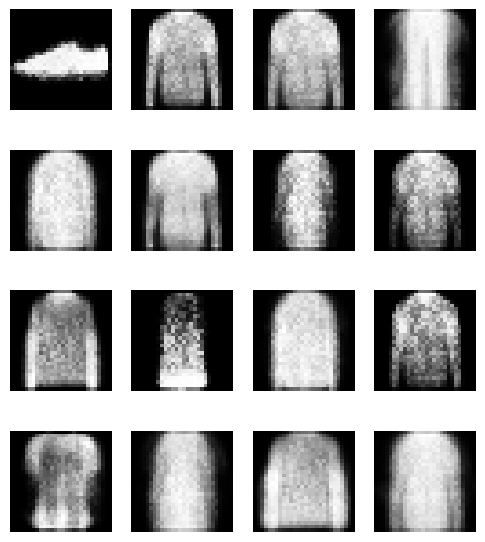

Training:  41%|████      | 48765/120000 [08:45<32:14, 36.82it/s, epoch=14, errD=-.233, errG=-.34]

Epoch 14 of 32, 3750 values per epoch


Training:  44%|████▍     | 52500/120000 [09:26<12:14, 91.86it/s, epoch=14, errD=-.263, errG=-.378]

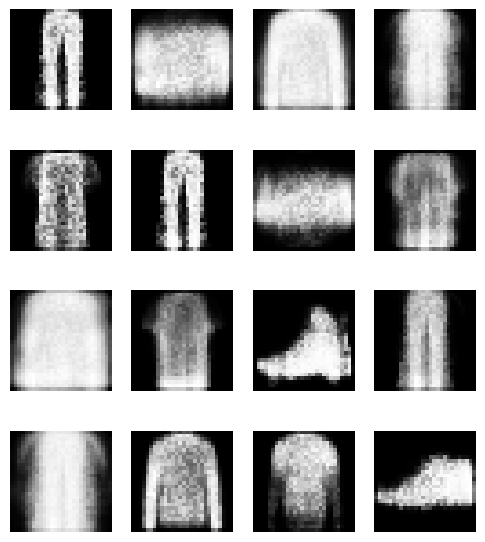

Training:  44%|████▍     | 52519/120000 [09:27<39:42, 28.32it/s, epoch=15, errD=-.314, errG=-.358]

Epoch 15 of 32, 3750 values per epoch


Training:  47%|████▋     | 56250/120000 [10:09<11:28, 92.53it/s, epoch=15, errD=-.259, errG=-.372]

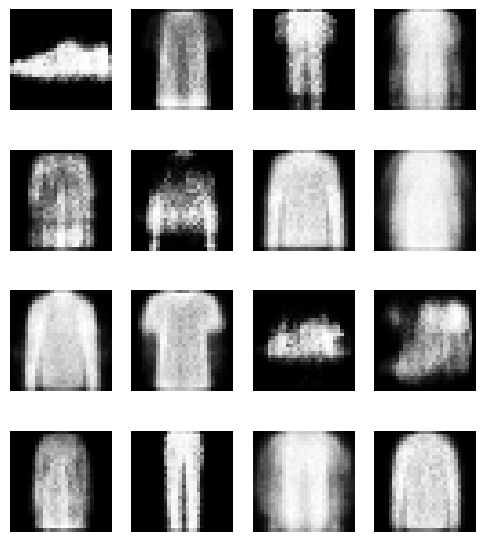

Training:  47%|████▋     | 56268/120000 [10:10<23:13, 45.74it/s, epoch=16, errD=-.259, errG=-.363]

Epoch 16 of 32, 3750 values per epoch


Training:  50%|█████     | 60000/120000 [10:51<12:05, 82.73it/s, epoch=16, errD=-.249, errG=-.379]

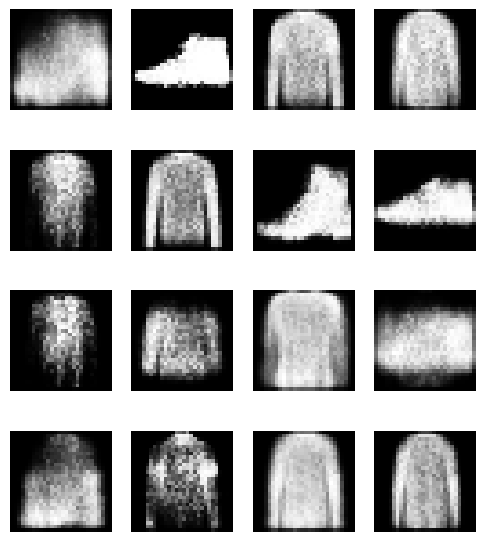

Training:  50%|█████     | 60016/120000 [10:52<35:30, 28.15it/s, epoch=17, errD=-.22, errG=-.41]  

Epoch 17 of 32, 3750 values per epoch


Training:  53%|█████▎    | 63750/120000 [11:34<09:52, 94.90it/s, epoch=17, errD=-.253, errG=-.373]

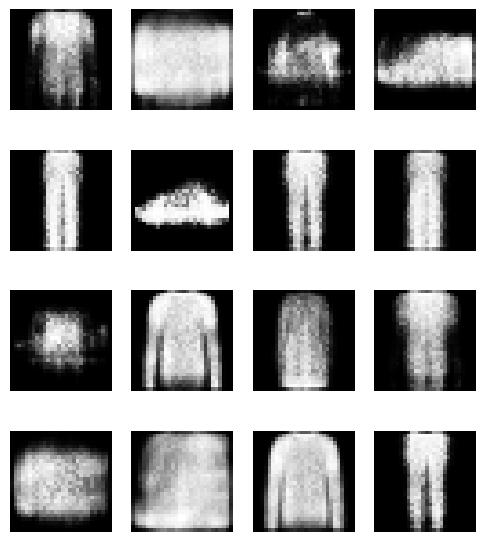

Training:  53%|█████▎    | 63765/120000 [11:35<36:01, 26.01it/s, epoch=18, errD=-.232, errG=-.41]

Epoch 18 of 32, 3750 values per epoch


Training:  56%|█████▋    | 67500/120000 [12:16<09:20, 93.73it/s, epoch=18, errD=-.234, errG=-.391]

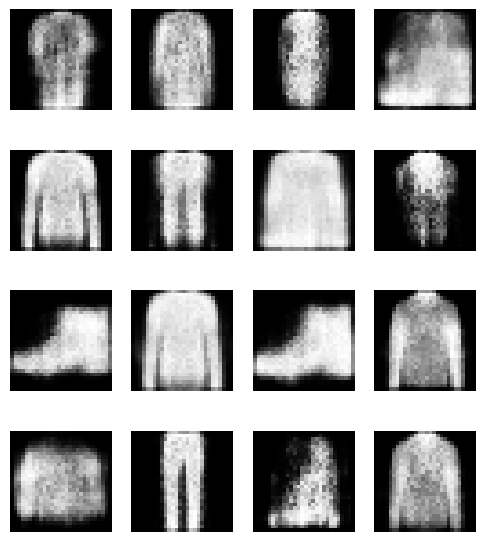

Training:  56%|█████▋    | 67519/120000 [12:17<20:18, 43.08it/s, epoch=19, errD=-.222, errG=-.389]

Epoch 19 of 32, 3750 values per epoch


Training:  59%|█████▉    | 71250/120000 [12:59<09:55, 81.81it/s, epoch=19, errD=-.238, errG=-.382]

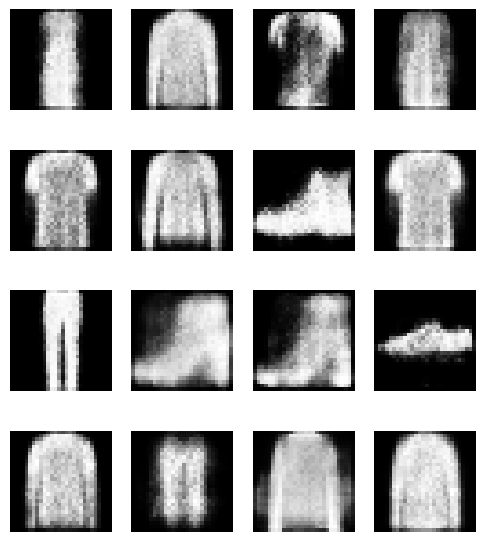

Training:  59%|█████▉    | 71269/120000 [13:00<21:43, 37.39it/s, epoch=20, errD=-.261, errG=-.37]

Epoch 20 of 32, 3750 values per epoch


Training:  62%|██████▎   | 75000/120000 [13:41<08:04, 92.87it/s, epoch=20, errD=-.215, errG=-.41]

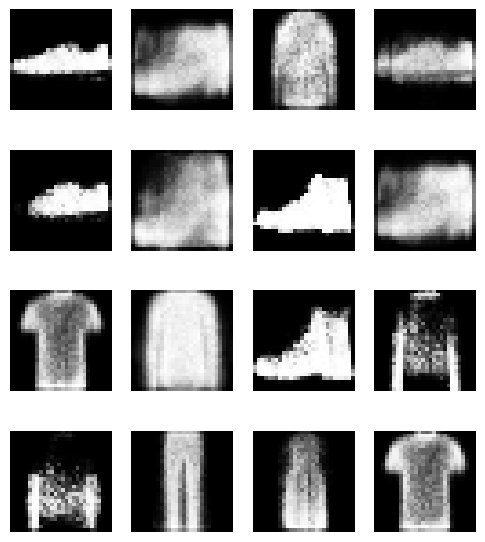

Training:  63%|██████▎   | 75015/120000 [13:42<22:23, 33.49it/s, epoch=21, errD=-.224, errG=-.458]

Epoch 21 of 32, 3750 values per epoch


Training:  66%|██████▌   | 78750/120000 [14:24<08:08, 84.37it/s, epoch=21, errD=-.219, errG=-.397]

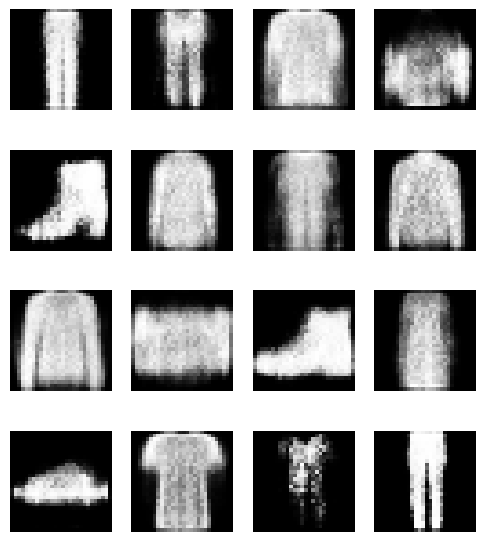

Training:  66%|██████▌   | 78770/120000 [14:24<16:21, 42.01it/s, epoch=22, errD=-.231, errG=-.341]

Epoch 22 of 32, 3750 values per epoch


Training:  69%|██████▉   | 82500/120000 [15:06<06:48, 91.81it/s, epoch=22, errD=-.207, errG=-.408]

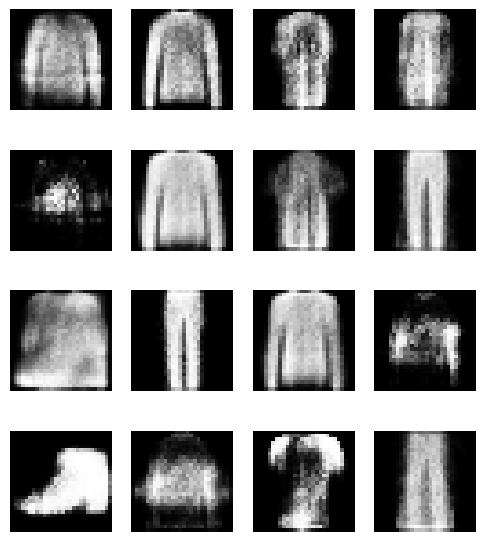

Training:  69%|██████▉   | 82519/120000 [15:07<19:41, 31.73it/s, epoch=23, errD=-.205, errG=-.412]

Epoch 23 of 32, 3750 values per epoch


Training:  72%|███████▏  | 86250/120000 [15:49<06:20, 88.71it/s, epoch=23, errD=-.192, errG=-.417]

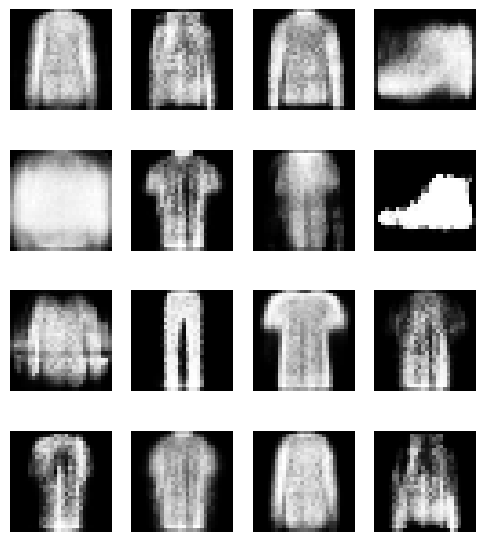

Training:  72%|███████▏  | 86268/120000 [15:50<17:05, 32.88it/s, epoch=24, errD=-.203, errG=-.424]

Epoch 24 of 32, 3750 values per epoch


Training:  75%|███████▌  | 90000/120000 [16:31<06:07, 81.71it/s, epoch=24, errD=-.193, errG=-.415]

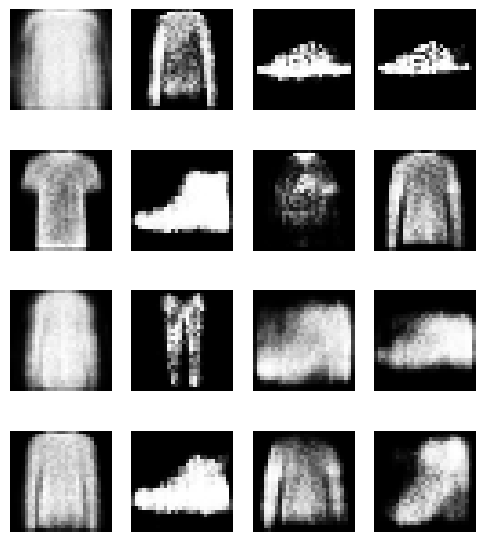

Training:  75%|███████▌  | 90018/120000 [16:32<12:16, 40.71it/s, epoch=25, errD=-.19, errG=-.452] 

Epoch 25 of 32, 3750 values per epoch


Training:  78%|███████▊  | 93750/120000 [17:13<04:37, 94.67it/s, epoch=25, errD=-.189, errG=-.423]

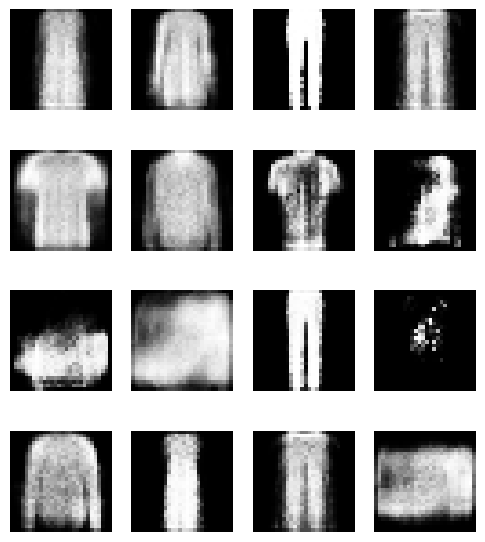

Training:  78%|███████▊  | 93766/120000 [17:14<10:18, 42.45it/s, epoch=26, errD=-.168, errG=-.425]

Epoch 26 of 32, 3750 values per epoch


Training:  81%|████████▏ | 97500/120000 [17:56<04:06, 91.30it/s, epoch=26, errD=-.181, errG=-.424]

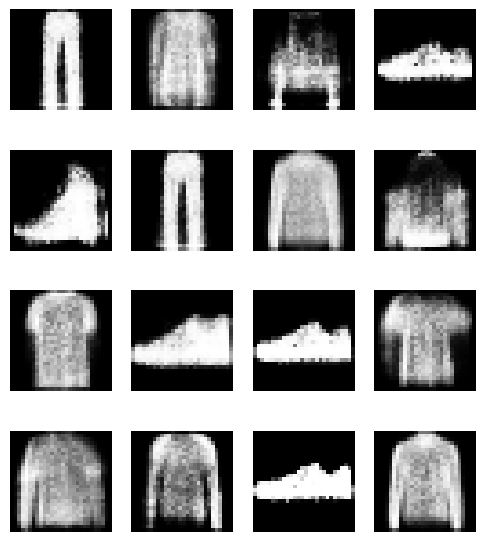

Training:  81%|████████▏ | 97518/120000 [17:57<10:56, 34.26it/s, epoch=27, errD=-.181, errG=-.453]

Epoch 27 of 32, 3750 values per epoch


Training:  84%|████████▍ | 101250/120000 [18:38<03:23, 92.21it/s, epoch=27, errD=-.181, errG=-.43]

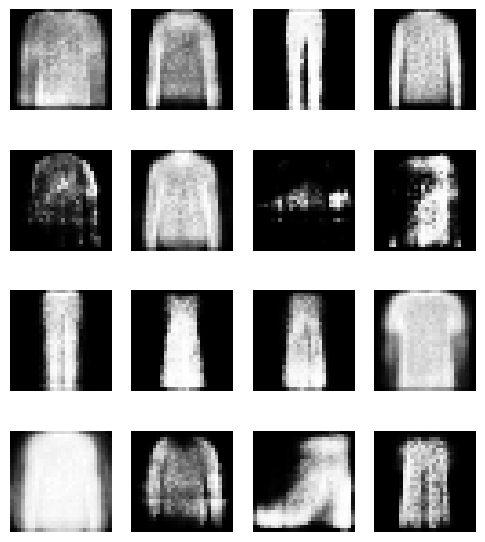

Training:  84%|████████▍ | 101266/120000 [18:39<08:52, 35.18it/s, epoch=28, errD=-.148, errG=-.469]

Epoch 28 of 32, 3750 values per epoch


Training:  88%|████████▊ | 105000/120000 [19:21<03:03, 81.87it/s, epoch=28, errD=-.18, errG=-.43]

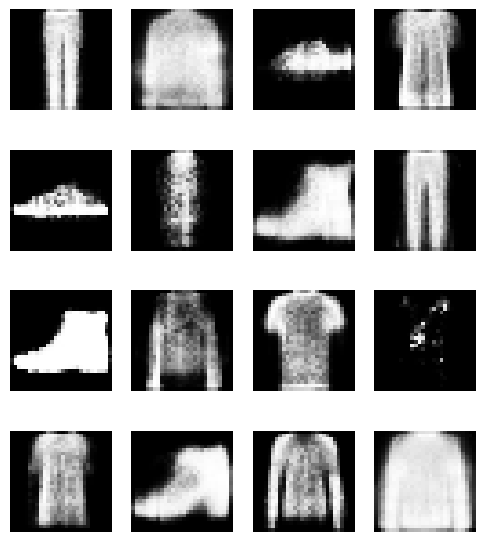

Training:  88%|████████▊ | 105014/120000 [19:22<07:21, 33.95it/s, epoch=29, errD=-.174, errG=-.448]

Epoch 29 of 32, 3750 values per epoch


Training:  91%|█████████ | 108750/120000 [20:03<01:59, 94.40it/s, epoch=29, errD=-.172, errG=-.441]

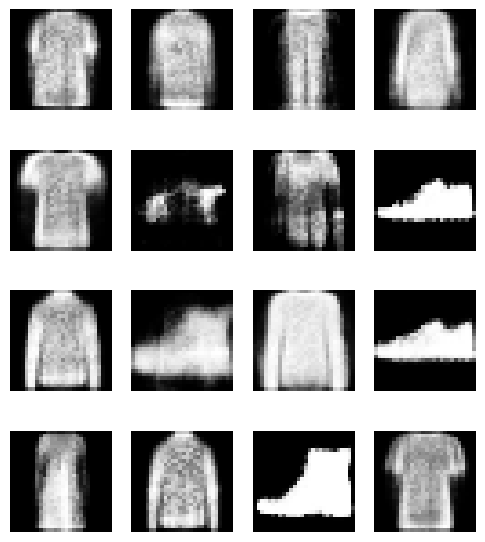

Training:  91%|█████████ | 108770/120000 [20:04<06:53, 27.16it/s, epoch=30, errD=-.249, errG=-.42]

Epoch 30 of 32, 3750 values per epoch


Training:  94%|█████████▍| 112500/120000 [20:45<01:23, 89.86it/s, epoch=30, errD=-.162, errG=-.456]

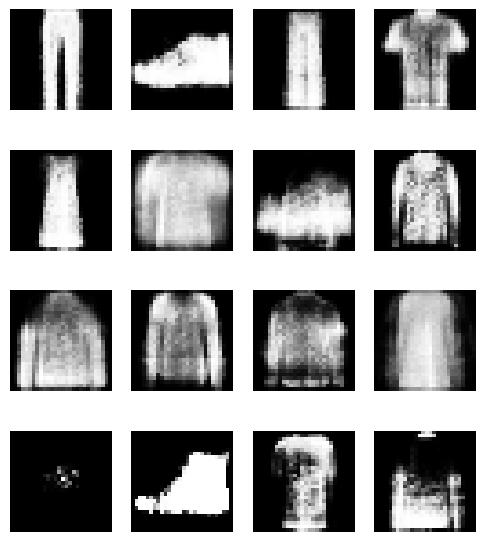

Training:  94%|█████████▍| 112519/120000 [20:46<02:51, 43.52it/s, epoch=31, errD=-.17, errG=-.457] 

Epoch 31 of 32, 3750 values per epoch


Training:  97%|█████████▋| 116250/120000 [21:27<00:47, 78.63it/s, epoch=31, errD=-.165, errG=-.45]

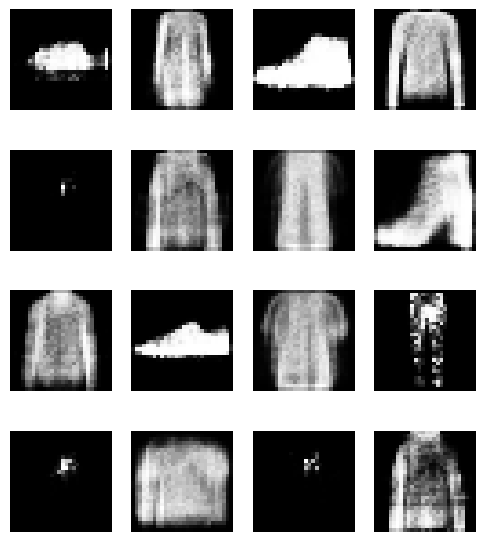

Training:  97%|█████████▋| 116266/120000 [21:28<01:50, 33.76it/s, epoch=32, errD=-.119, errG=-.496]

Epoch 32 of 32, 3750 values per epoch


Training: 100%|██████████| 120000/120000 [22:08<00:00, 93.55it/s, epoch=32, errD=-.155, errG=-.455]

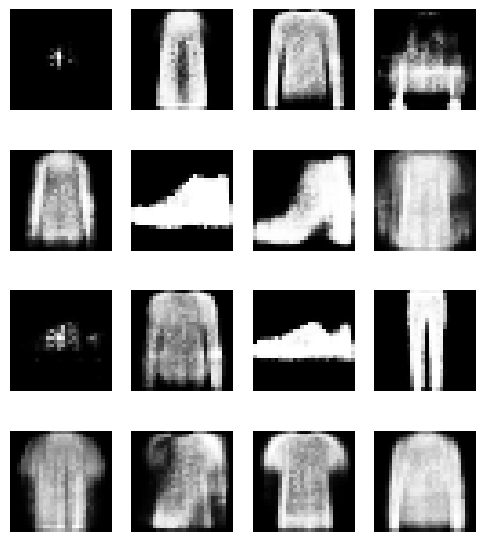

Training: 100%|██████████| 120000/120000 [22:09<00:00, 90.27it/s, epoch=32, errD=-.155, errG=-.455]


In [12]:
from tqdm import tqdm

config.num_epochs = 32

# Инициализация списков для хранения ошибок
errD = [list() for _ in range(config.num_epochs)]
errG = [list() for _ in range(config.num_epochs)]
N = len(dataloader)
c = 0.01

# Создание объекта tqdm для отображения прогресса обучения
progress_bar = tqdm(total=config.num_epochs * N, desc='Training', position=0)

for epoch in range(config.num_epochs):
    # Вывод количества значений в одной эпохе
    print(f'Epoch {epoch+1} of {config.num_epochs}, {N} values per epoch')

    for iteration, (images, cat) in enumerate(dataloader):
        # Шаг градиентного подъема для критика
        discriminator.zero_grad()
        noise.data.normal_(0, 1)
        images = images.view(images.shape[0], -1).to(device)
        d_loss_real = discriminator(images).view(-1).mean(0)

        d_loss_fake = discriminator(generator(noise)).view(-1).mean(0)
        d_loss = -(d_loss_real - d_loss_fake)
        d_loss.backward()

        errD[epoch].append(d_loss.item())

        optim_D.step()

        # Ограничение весов дискриминатора
        for param in discriminator.parameters():
            param.data.clamp_(-c, c)

        # Шаг градиентного спуска для генератора
        if iteration % config.generator_freq == 0:
            generator.zero_grad()
            noise.data.normal_(0, 1)
            g_loss = -discriminator(generator(noise)).view(-1).mean(0)
            g_loss.backward()
            errG[epoch].append(g_loss.item())
            optim_G.step()

        # Обновление прогресса обучения
        progress_bar.update(1)
        progress_bar.set_postfix(epoch=epoch+1, errD=np.mean(errD[epoch]), errG=np.mean(errG[epoch]))

    # Генерация и вывод изображений после каждой эпохи
    noise.data.normal_(0, 1)
    fake = generator(noise)

    plt.figure(figsize=(6, 7))
    for i in range(config.batch_size):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

# Завершение отображения прогресса обучения
progress_bar.close()

## Визуализация ошибок обучения генератора и дискриминатора

Вычисление средних ошибок для каждой эпохи и затем построение графиков этих ошибок для визуального представления прогресса обучения.

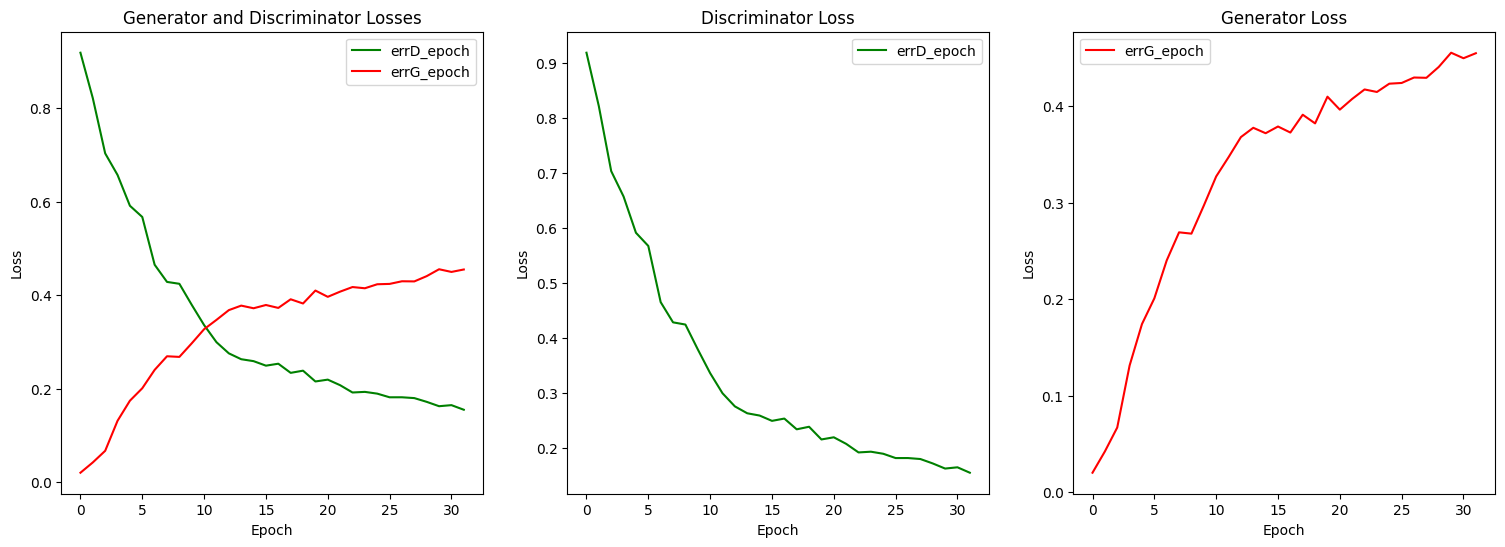

In [13]:
errD_epoch = -np.array(errD).mean(1)
errG_epoch = -np.array(errG).mean(1)

fig, ax = plt.subplots(1, 3, figsize=(18.5, 6))

# График ошибок генератора и дискриминатора
ax[0].plot(errD_epoch, color='green', label='errD_epoch')
ax[0].plot(errG_epoch, color='red', label='errG_epoch')
ax[0].set_title('Generator and Discriminator Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# График ошибки дискриминатора
ax[1].plot(errD_epoch, color='green', label='errD_epoch')
ax[1].set_title('Discriminator Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# График ошибки генератора
ax[2].plot(errG_epoch, color='red', label='errG_epoch')
ax[2].set_title('Generator Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

plt.show()

## Генерация и визуализация "синтетических" изображений

Генерация шума, использование генератора для создания "синтетических" изображений из этого шума, визуализация этих изображений.

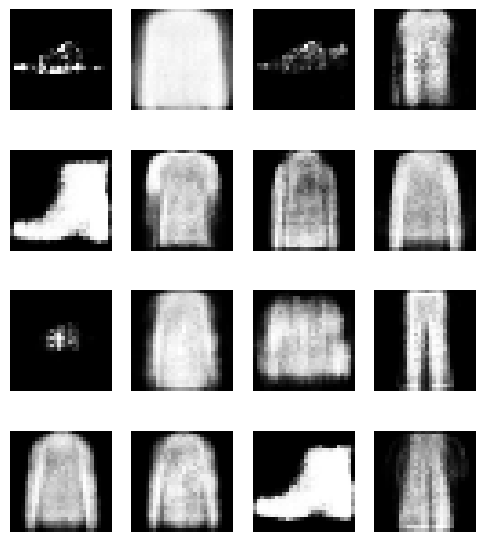

In [14]:
# Генерация шума
noise.data.normal_(0, 1)

# Генерация изображений с помощью генератора
fake = generator(noise)

# Создание фигуры для отображения изображений
plt.figure(figsize=(6, 7))

# Цикл по сгенерированным изображениям
for i in range(config.batch_size):
    # Создание подграфика для каждого изображения
    plt.subplot(4, 4, i + 1)

    # Отображение изображения
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

    # Удаление осей
    plt.axis('off')

# Отображение фигуры с изображениями
plt.show()

## WGAN c штрафом градиентов

In [15]:
def compute_gp(netD, real_data, fake_data):
    # Размер пакета
    batch_size = real_data.size(0)

    # Генерация случайных чисел для интерполяции между реальными и сгенерированными данными
    eps = torch.rand(real_data.size()).to(real_data.device)
    eps = Variable(eps.expand_as(real_data))

    # Вычисление интерполяции
    interpolation = eps * real_data + (1 - eps) * fake_data

    # Применение дискриминатора к интерполированным данным
    interp_logits = netD(interpolation)

    # Создание градиентных выходов для последующего вычисления градиентов
    grad_outputs = torch.ones_like(interp_logits)

    # Вычисление градиентов
    gradients = autograd.grad(
        outputs=interp_logits,
        inputs=interpolation,
        grad_outputs=grad_outputs,
        create_graph=True,
        retain_graph=True,
    )[0]

    # Изменение формы градиентов для вычисления нормы
    gradients = gradients.view(batch_size, -1)

    # Вычисление нормы градиента
    grad_norm = gradients.norm(2, 1)

    # Возвращение среднего квадрата разности между нормой градиента и 1 (штраф градиента)
    return torch.mean((grad_norm - 1) ** 2)

## Обучение WGAN со штрафом градиента

Training:   0%|          | 0/135000 [00:00<?, ?it/s]

Epoch 1 of 36, 3750 values per epoch


Training:   3%|▎         | 3750/135000 [00:56<30:44, 71.14it/s, epoch=1, errD=-.944, errG=-.00932]

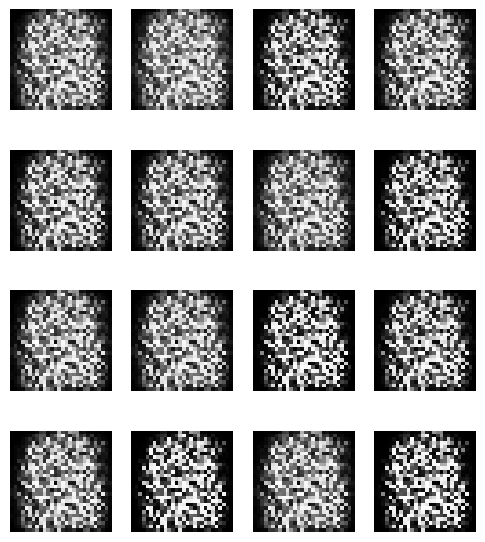

Training:   3%|▎         | 3763/135000 [00:57<1:03:22, 34.51it/s, epoch=2, errD=-.979, errG=-.00512]

Epoch 2 of 36, 3750 values per epoch


Training:   6%|▌         | 7500/135000 [01:53<33:20, 63.73it/s, epoch=2, errD=-.931, errG=-.0129]

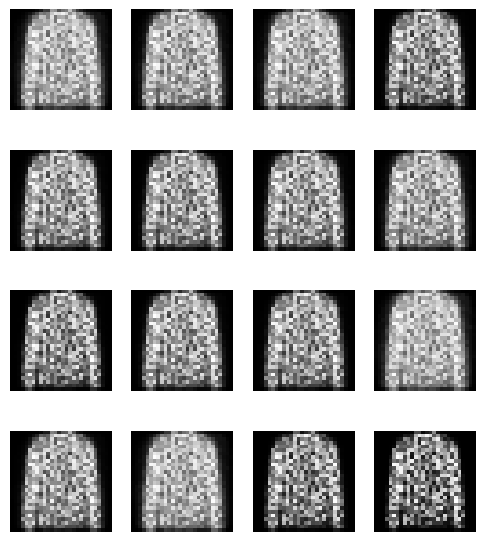

Training:   6%|▌         | 7512/135000 [01:54<2:08:42, 16.51it/s, epoch=3, errD=-.923, errG=-.0195]

Epoch 3 of 36, 3750 values per epoch


Training:   8%|▊         | 11250/135000 [02:51<29:46, 69.27it/s, epoch=3, errD=-.931, errG=-.0151]

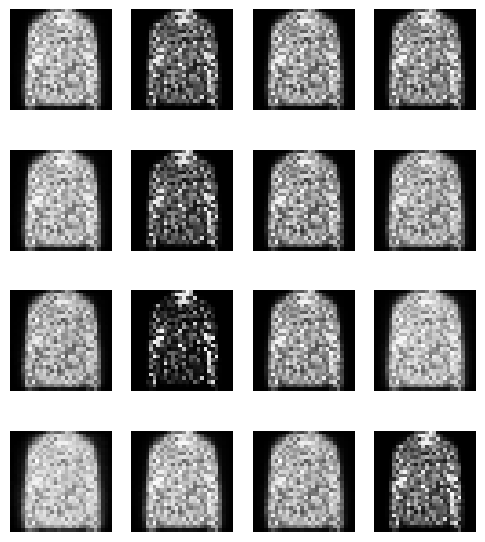

Training:   8%|▊         | 11264/135000 [02:52<1:17:45, 26.52it/s, epoch=4, errD=-.922, errG=-.0111]

Epoch 4 of 36, 3750 values per epoch


Training:  11%|█         | 15000/135000 [03:48<30:13, 66.17it/s, epoch=4, errD=-.925, errG=-.0142]

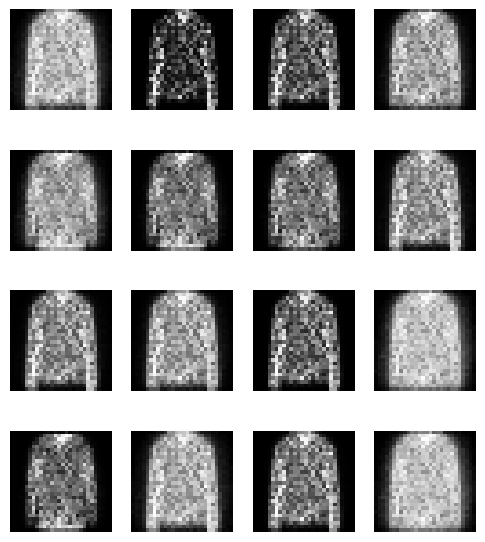

Training:  11%|█         | 15014/135000 [03:48<1:02:02, 32.23it/s, epoch=5, errD=-.94, errG=-.0123]

Epoch 5 of 36, 3750 values per epoch


Training:  14%|█▍        | 18750/135000 [04:45<31:32, 61.41it/s, epoch=5, errD=-.933, errG=-.0137]

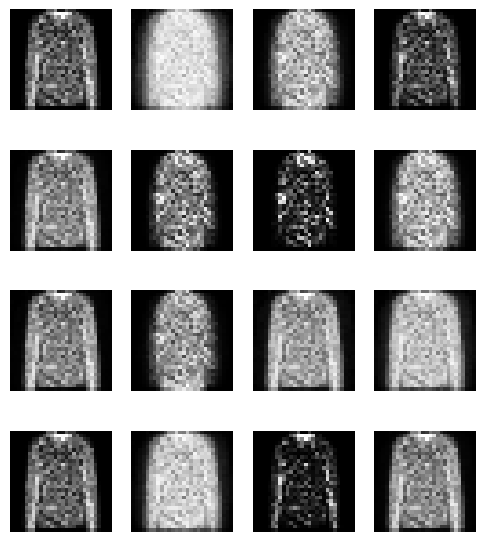

Training:  14%|█▍        | 18763/135000 [04:46<1:45:00, 18.45it/s, epoch=6, errD=-.943, errG=-.0113]

Epoch 6 of 36, 3750 values per epoch


Training:  17%|█▋        | 22500/135000 [05:42<29:27, 63.66it/s, epoch=6, errD=-.932, errG=-.0153]

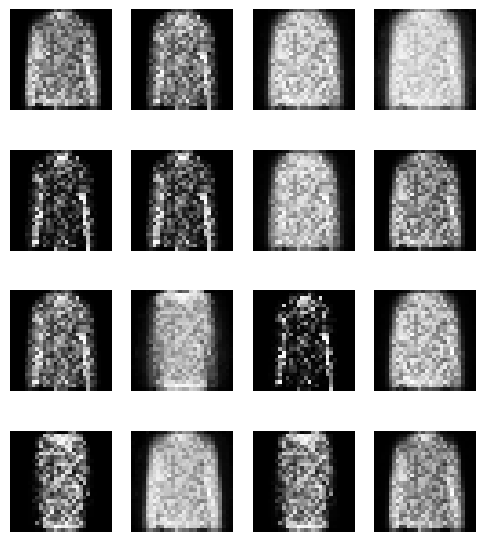

Training:  17%|█▋        | 22513/135000 [05:43<1:19:57, 23.44it/s, epoch=7, errD=-.926, errG=-.0254]

Epoch 7 of 36, 3750 values per epoch


Training:  19%|█▉        | 26250/135000 [06:39<27:37, 65.63it/s, epoch=7, errD=-.924, errG=-.0203]

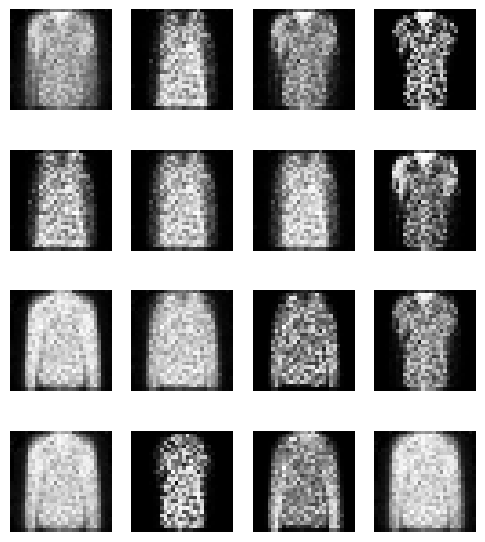

Training:  19%|█▉        | 26262/135000 [06:40<59:50, 30.29it/s, epoch=8, errD=-.926, errG=-.0237]

Epoch 8 of 36, 3750 values per epoch


Training:  22%|██▏       | 30000/135000 [07:35<27:02, 64.70it/s, epoch=8, errD=-.912, errG=-.0232]

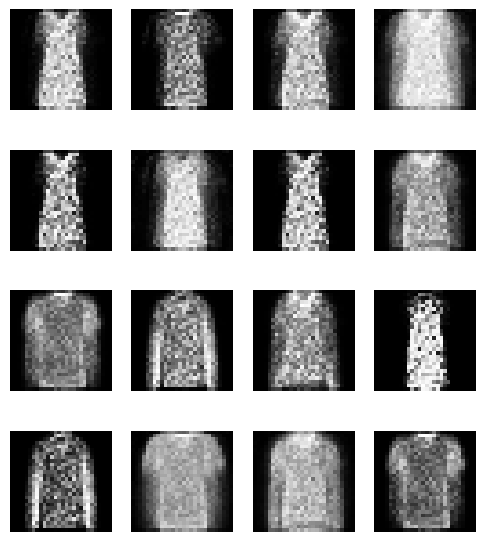

Training:  22%|██▏       | 30014/135000 [07:36<1:12:09, 24.25it/s, epoch=9, errD=-.908, errG=-.0168]

Epoch 9 of 36, 3750 values per epoch


Training:  25%|██▌       | 33750/135000 [08:31<25:54, 65.15it/s, epoch=9, errD=-.904, errG=-.0254]

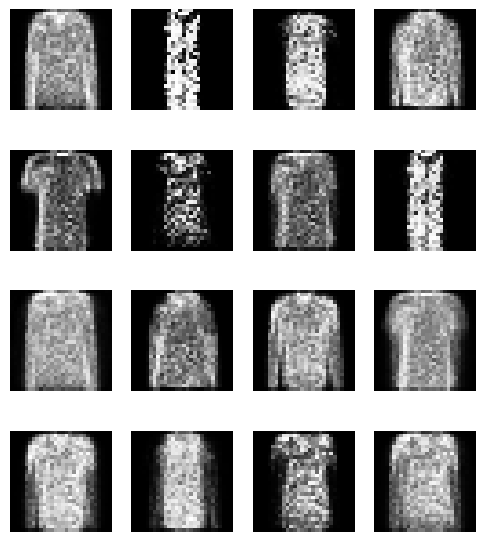

Training:  25%|██▌       | 33764/135000 [08:32<52:51, 31.92it/s, epoch=10, errD=-.905, errG=-.0313]

Epoch 10 of 36, 3750 values per epoch


Training:  28%|██▊       | 37500/135000 [09:28<25:10, 64.57it/s, epoch=10, errD=-.889, errG=-.0304]

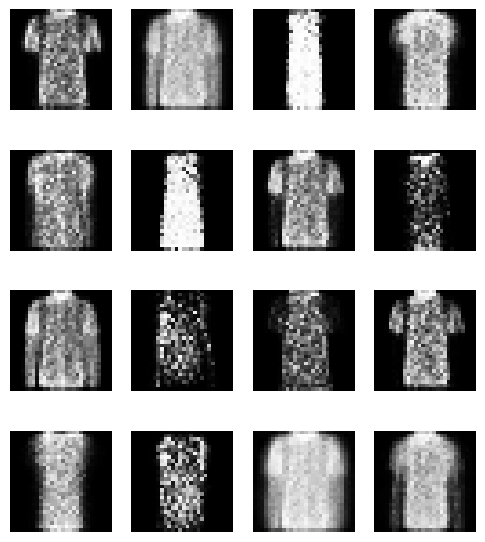

Training:  28%|██▊       | 37511/135000 [09:29<1:04:15, 25.28it/s, epoch=11, errD=-.859, errG=-.0361]

Epoch 11 of 36, 3750 values per epoch


Training:  31%|███       | 41250/135000 [10:25<24:02, 64.98it/s, epoch=11, errD=-.872, errG=-.0381]

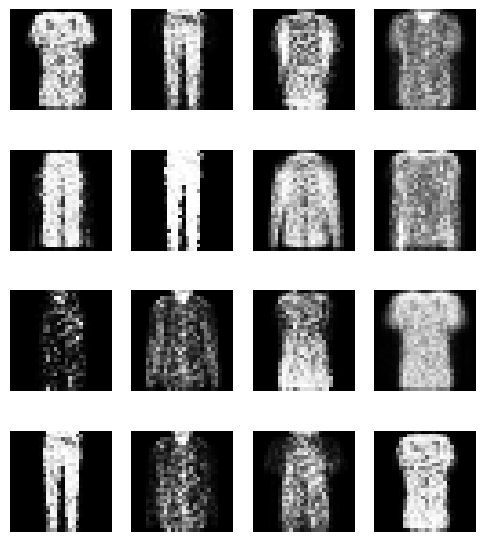

Training:  31%|███       | 41261/135000 [10:26<1:18:29, 19.90it/s, epoch=12, errD=-.872, errG=-.0262]

Epoch 12 of 36, 3750 values per epoch


Training:  33%|███▎      | 45000/135000 [11:23<21:52, 68.59it/s, epoch=12, errD=-.852, errG=-.0458]

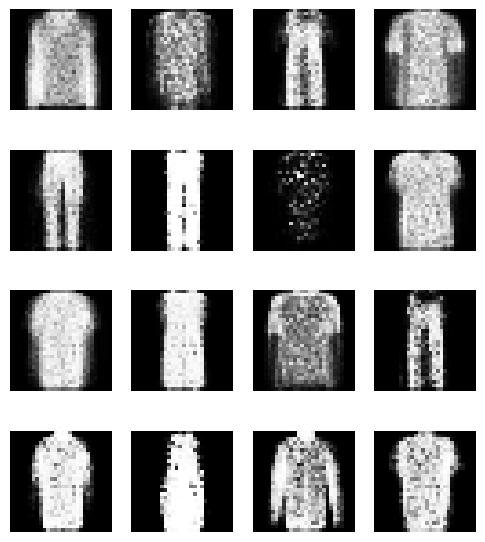

Training:  33%|███▎      | 45013/135000 [11:24<52:18, 28.68it/s, epoch=13, errD=-.847, errG=-.0444]

Epoch 13 of 36, 3750 values per epoch


Training:  36%|███▌      | 48750/135000 [12:21<25:07, 57.22it/s, epoch=13, errD=-.844, errG=-.0497]

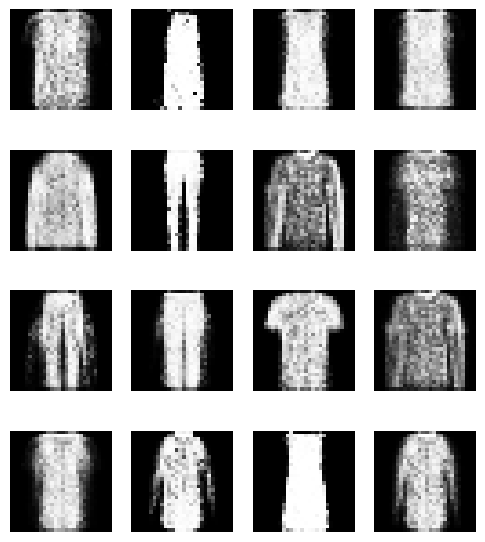

Training:  36%|███▌      | 48764/135000 [12:22<46:31, 30.89it/s, epoch=14, errD=-.789, errG=-.0566]

Epoch 14 of 36, 3750 values per epoch


Training:  39%|███▉      | 52500/135000 [13:21<22:31, 61.03it/s, epoch=14, errD=-.832, errG=-.0548]

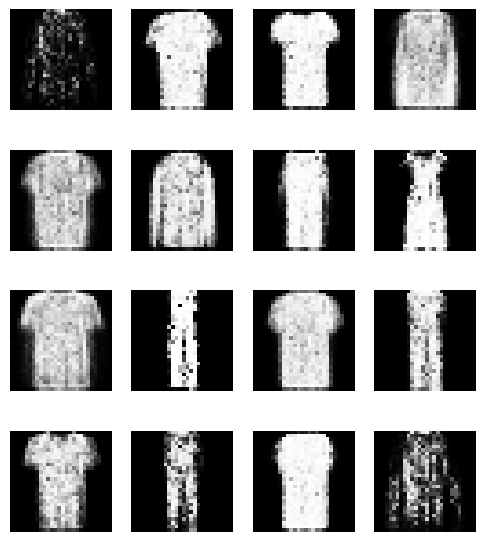

Training:  39%|███▉      | 52510/135000 [13:22<1:05:46, 20.90it/s, epoch=15, errD=-.837, errG=-.0414]

Epoch 15 of 36, 3750 values per epoch


Training:  42%|████▏     | 56250/135000 [14:21<20:32, 63.90it/s, epoch=15, errD=-.816, errG=-.0592]

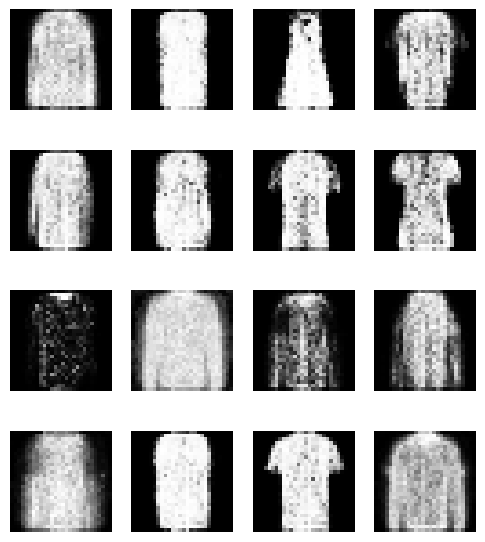

Training:  42%|████▏     | 56260/135000 [14:21<43:32, 30.14it/s, epoch=16, errD=-.794, errG=-.0899]

Epoch 16 of 36, 3750 values per epoch


Training:  44%|████▍     | 60000/135000 [15:18<18:32, 67.40it/s, epoch=16, errD=-.799, errG=-.0675]

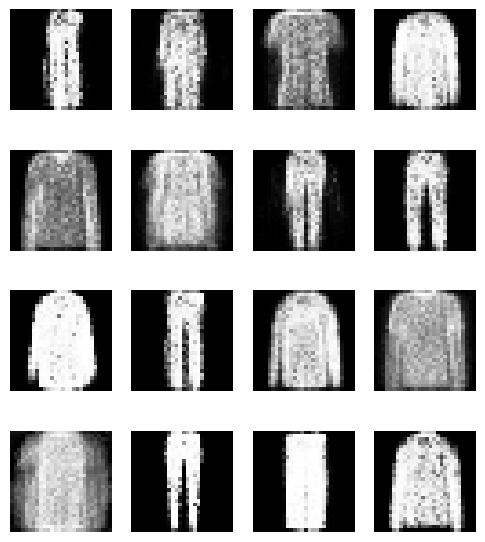

Training:  44%|████▍     | 60015/135000 [15:19<37:17, 33.51it/s, epoch=17, errD=-.786, errG=-.0506]

Epoch 17 of 36, 3750 values per epoch


Training:  47%|████▋     | 63750/135000 [16:17<17:31, 67.76it/s, epoch=17, errD=-.782, errG=-.0727]

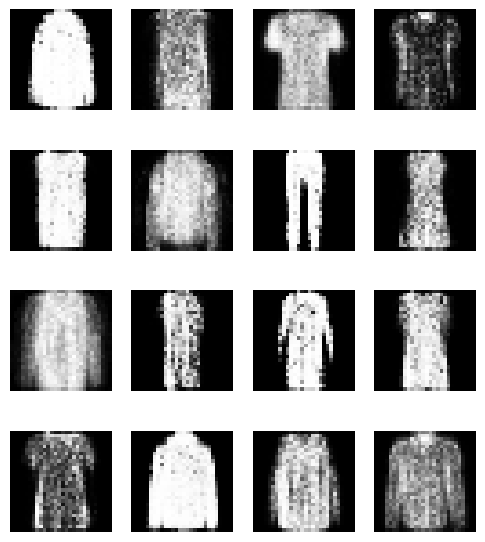

Training:  47%|████▋     | 63761/135000 [16:18<52:50, 22.47it/s, epoch=18, errD=-.753, errG=-.0582]

Epoch 18 of 36, 3750 values per epoch


Training:  50%|█████     | 67500/135000 [17:15<18:08, 62.00it/s, epoch=18, errD=-.766, errG=-.0791]

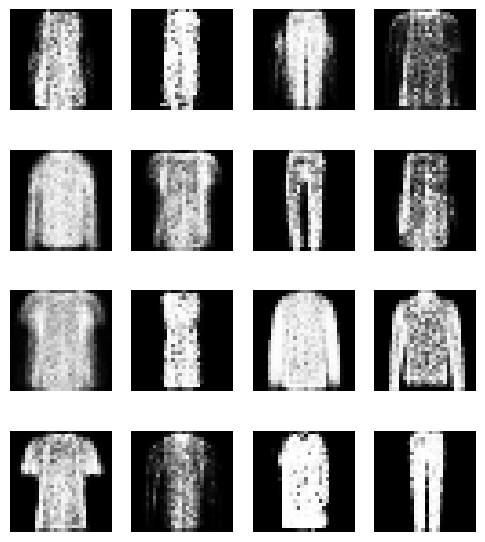

Training:  50%|█████     | 67514/135000 [17:16<37:21, 30.11it/s, epoch=19, errD=-.739, errG=-.0893]

Epoch 19 of 36, 3750 values per epoch


Training:  53%|█████▎    | 71250/135000 [18:12<15:26, 68.79it/s, epoch=19, errD=-.76, errG=-.0833]

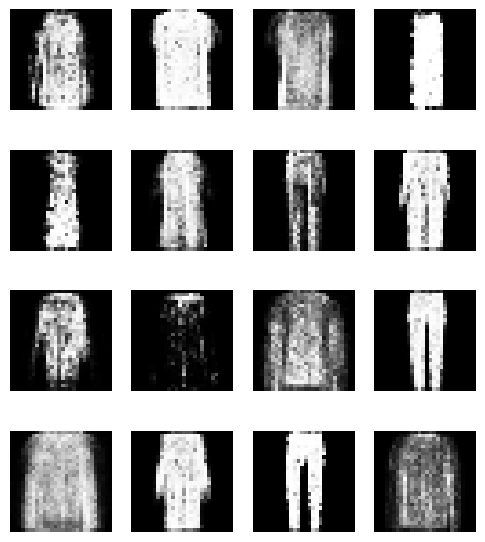

Training:  53%|█████▎    | 71264/135000 [18:13<32:56, 32.25it/s, epoch=20, errD=-.761, errG=-.0965]

Epoch 20 of 36, 3750 values per epoch


Training:  56%|█████▌    | 75000/135000 [19:09<16:23, 61.04it/s, epoch=20, errD=-.744, errG=-.0892]

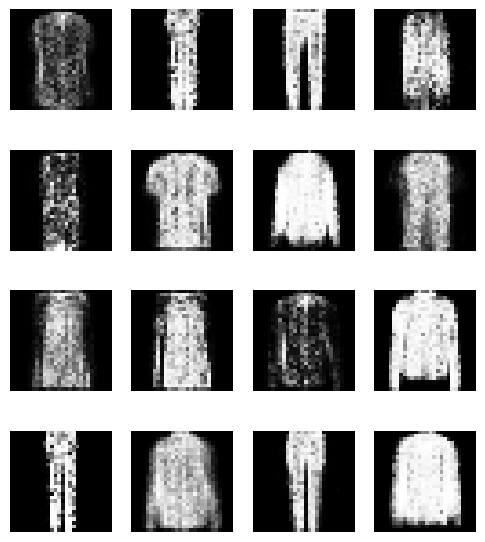

Training:  56%|█████▌    | 75011/135000 [19:10<50:58, 19.62it/s, epoch=21, errD=-.709, errG=-.088]

Epoch 21 of 36, 3750 values per epoch


Training:  58%|█████▊    | 78750/135000 [20:06<14:08, 66.29it/s, epoch=21, errD=-.736, errG=-.0966]

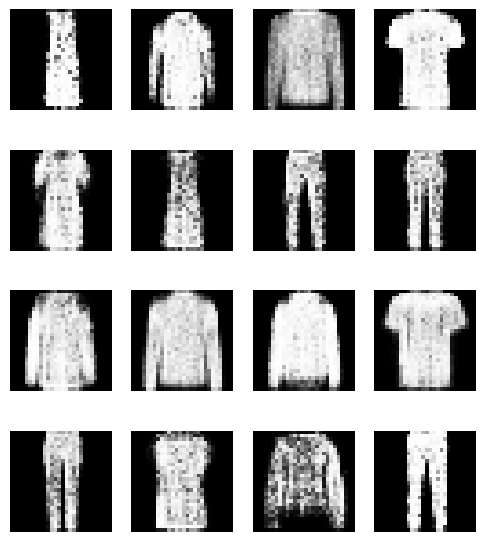

Training:  58%|█████▊    | 78764/135000 [20:07<29:48, 31.44it/s, epoch=22, errD=-.766, errG=-.0845]

Epoch 22 of 36, 3750 values per epoch


Training:  61%|██████    | 82500/135000 [21:04<12:17, 71.23it/s, epoch=22, errD=-.722, errG=-.102]

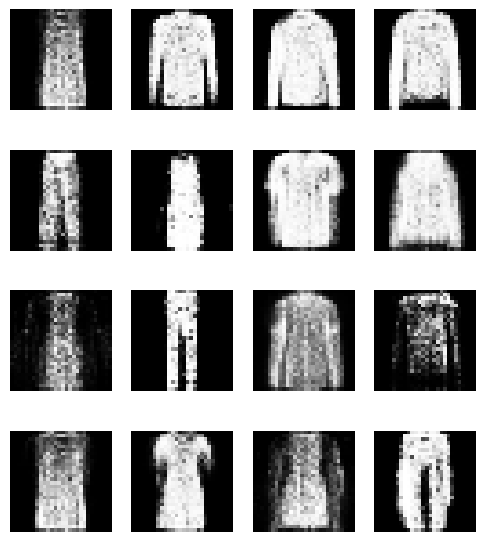

Training:  61%|██████    | 82513/135000 [21:05<26:38, 32.83it/s, epoch=23, errD=-.702, errG=-.0675]

Epoch 23 of 36, 3750 values per epoch


Training:  64%|██████▍   | 86250/135000 [22:03<13:18, 61.07it/s, epoch=23, errD=-.719, errG=-.1]

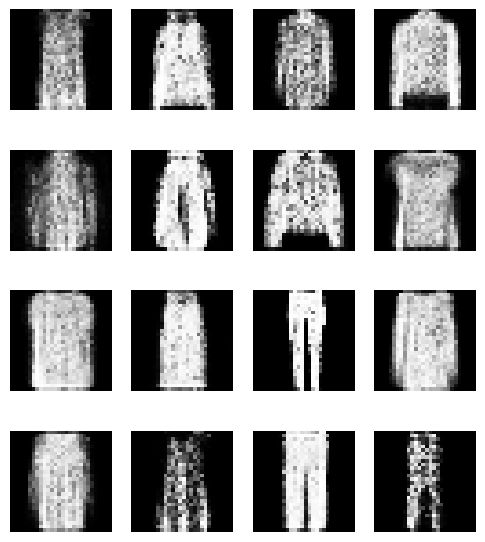

Training:  64%|██████▍   | 86262/135000 [22:04<36:47, 22.08it/s, epoch=24, errD=-.708, errG=-.146]

Epoch 24 of 36, 3750 values per epoch


Training:  67%|██████▋   | 90000/135000 [23:00<10:53, 68.85it/s, epoch=24, errD=-.714, errG=-.0989]

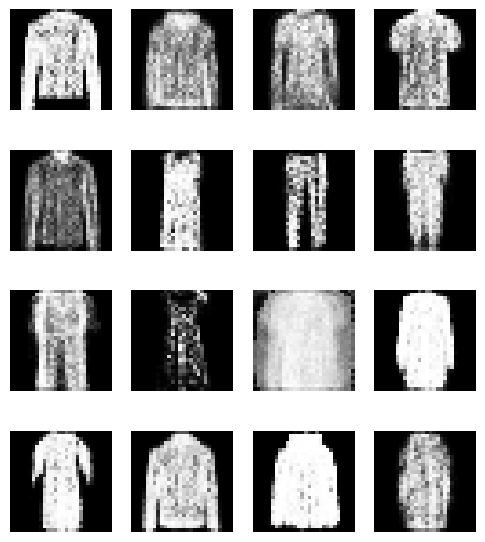

Training:  67%|██████▋   | 90011/135000 [23:01<30:12, 24.82it/s, epoch=25, errD=-.741, errG=-.124]

Epoch 25 of 36, 3750 values per epoch


Training:  69%|██████▉   | 93750/135000 [23:59<10:45, 63.93it/s, epoch=25, errD=-.702, errG=-.105]

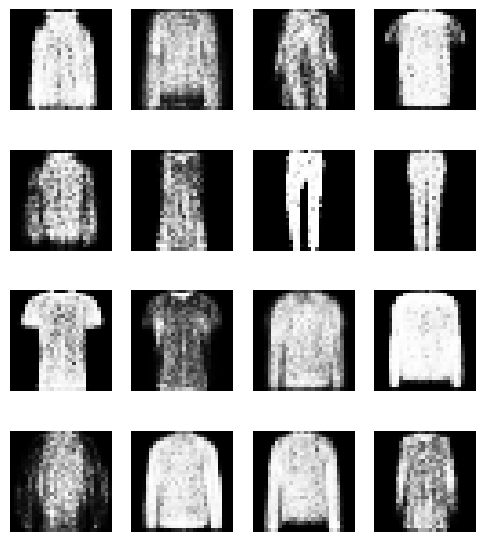

Training:  69%|██████▉   | 93761/135000 [24:00<23:10, 29.66it/s, epoch=26, errD=-.709, errG=-.0913]

Epoch 26 of 36, 3750 values per epoch


Training:  72%|███████▏  | 97500/135000 [24:57<09:22, 66.68it/s, epoch=26, errD=-.696, errG=-.107]

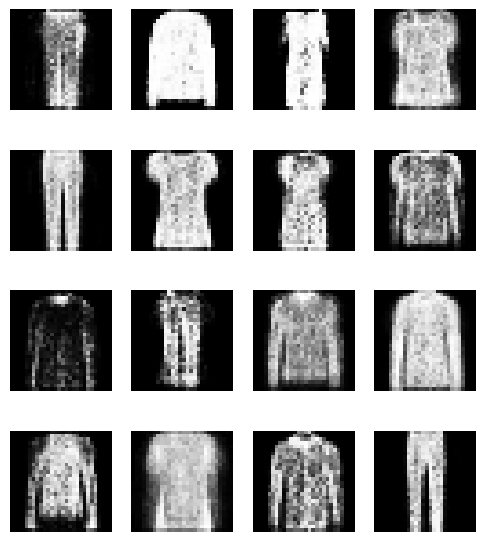

Training:  72%|███████▏  | 97511/135000 [24:58<28:02, 22.29it/s, epoch=27, errD=-.734, errG=-.0867]

Epoch 27 of 36, 3750 values per epoch


Training:  75%|███████▌  | 101250/135000 [25:55<08:30, 66.07it/s, epoch=27, errD=-.698, errG=-.107]

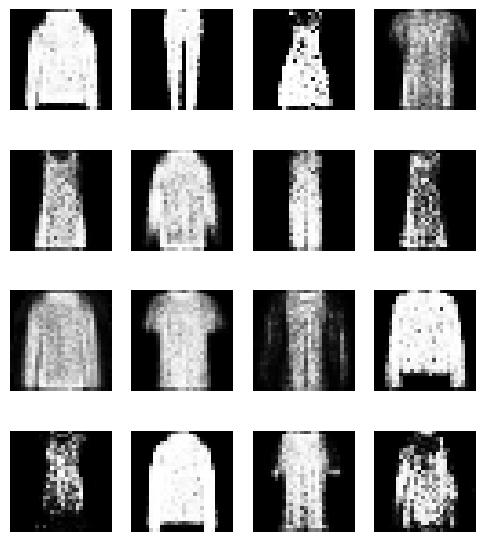

Training:  75%|███████▌  | 101261/135000 [25:56<18:38, 30.17it/s, epoch=28, errD=-.707, errG=-.128]

Epoch 28 of 36, 3750 values per epoch


Training:  78%|███████▊  | 105000/135000 [26:53<07:07, 70.24it/s, epoch=28, errD=-.69, errG=-.114]

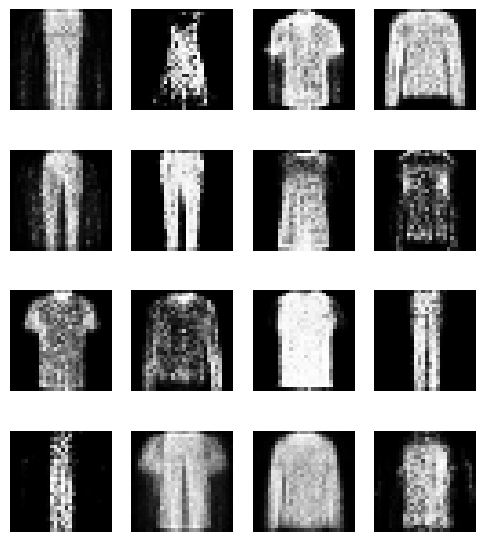

Training:  78%|███████▊  | 105012/135000 [26:54<15:11, 32.91it/s, epoch=29, errD=-.624, errG=-.13]

Epoch 29 of 36, 3750 values per epoch


Training:  81%|████████  | 108750/135000 [28:03<07:06, 61.56it/s, epoch=29, errD=-.69, errG=-.111]

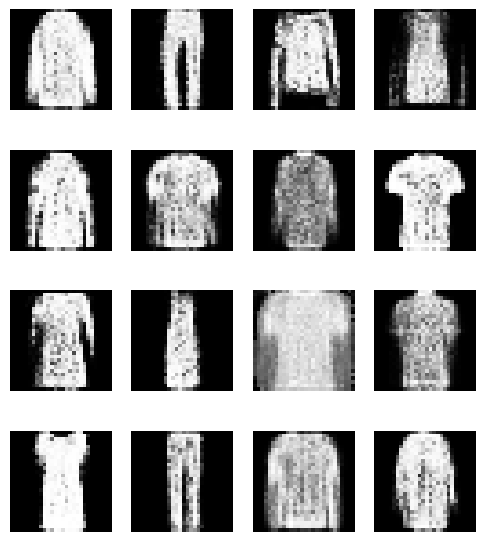

Training:  81%|████████  | 108760/135000 [28:04<24:03, 18.17it/s, epoch=30, errD=-.682, errG=-.115]

Epoch 30 of 36, 3750 values per epoch


Training:  83%|████████▎ | 112500/135000 [29:01<05:27, 68.81it/s, epoch=30, errD=-.684, errG=-.119]

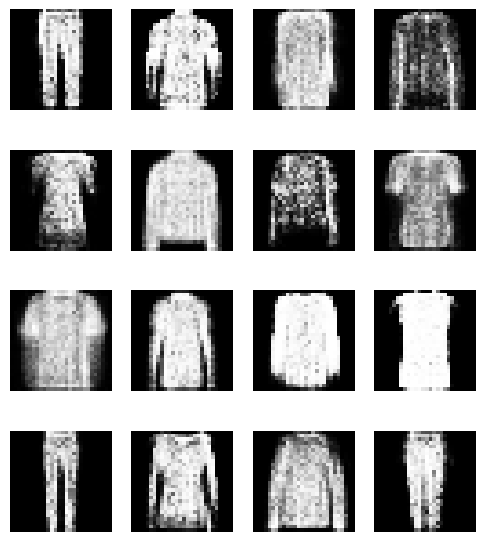

Training:  83%|████████▎ | 112513/135000 [29:02<14:07, 26.52it/s, epoch=31, errD=-.726, errG=-.15]

Epoch 31 of 36, 3750 values per epoch


Training:  86%|████████▌ | 116250/135000 [29:59<04:32, 68.70it/s, epoch=31, errD=-.679, errG=-.117]

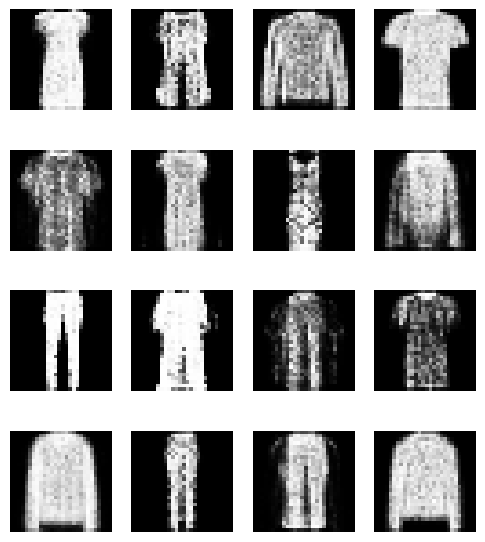

Training:  86%|████████▌ | 116264/135000 [30:00<09:47, 31.88it/s, epoch=32, errD=-.669, errG=-.121]

Epoch 32 of 36, 3750 values per epoch


Training:  89%|████████▉ | 120000/135000 [30:57<03:33, 70.19it/s, epoch=32, errD=-.677, errG=-.117]

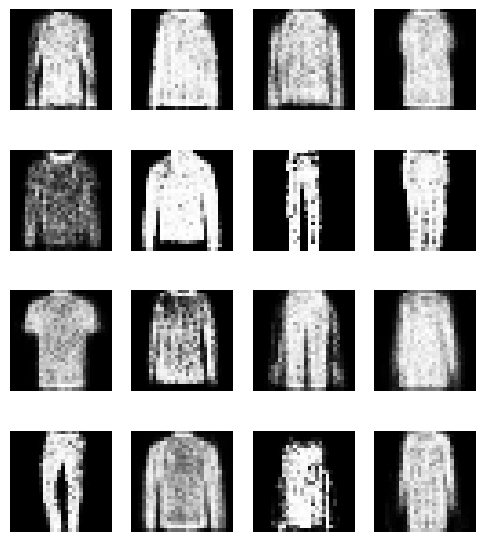

Training:  89%|████████▉ | 120013/135000 [30:58<12:23, 20.15it/s, epoch=33, errD=-.64, errG=-.127] 

Epoch 33 of 36, 3750 values per epoch


Training:  92%|█████████▏| 123750/135000 [31:55<02:46, 67.40it/s, epoch=33, errD=-.674, errG=-.115]

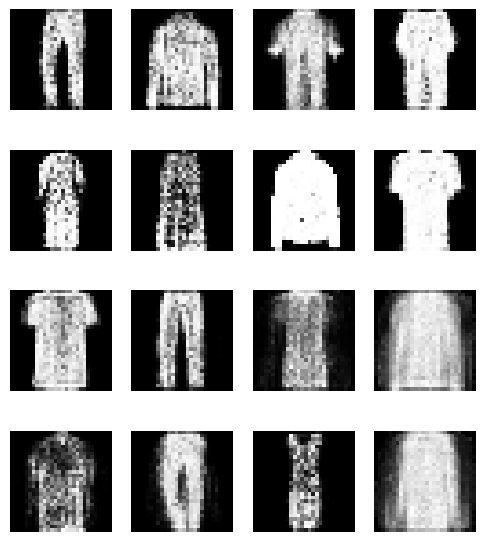

Training:  92%|█████████▏| 123764/135000 [31:56<05:53, 31.75it/s, epoch=34, errD=-.654, errG=-.179]

Epoch 34 of 36, 3750 values per epoch


Training:  94%|█████████▍| 127500/135000 [32:55<01:57, 63.96it/s, epoch=34, errD=-.669, errG=-.119]

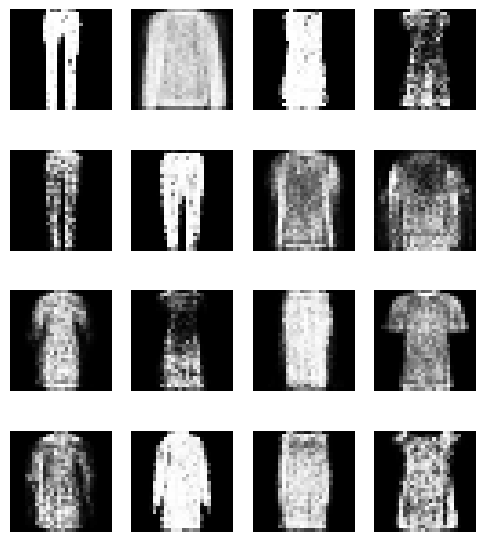

Training:  94%|█████████▍| 127511/135000 [32:56<04:21, 28.61it/s, epoch=35, errD=-.681, errG=-.11] 

Epoch 35 of 36, 3750 values per epoch


Training:  97%|█████████▋| 131250/135000 [33:55<01:03, 58.71it/s, epoch=35, errD=-.663, errG=-.124]

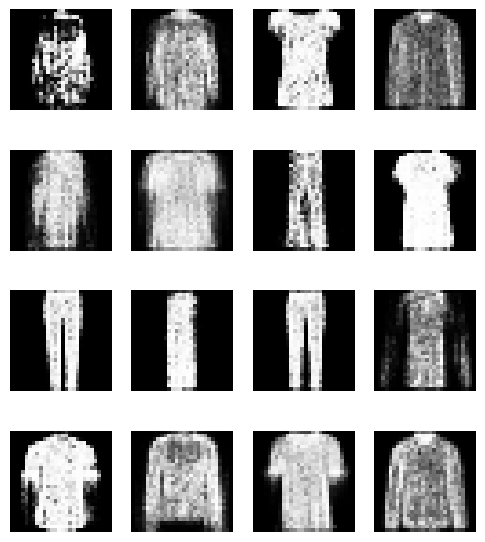

Training:  97%|█████████▋| 131261/135000 [33:56<03:05, 20.19it/s, epoch=36, errD=-.661, errG=-.115]

Epoch 36 of 36, 3750 values per epoch


Training: 100%|██████████| 135000/135000 [34:55<00:00, 60.94it/s, epoch=36, errD=-.655, errG=-.126]

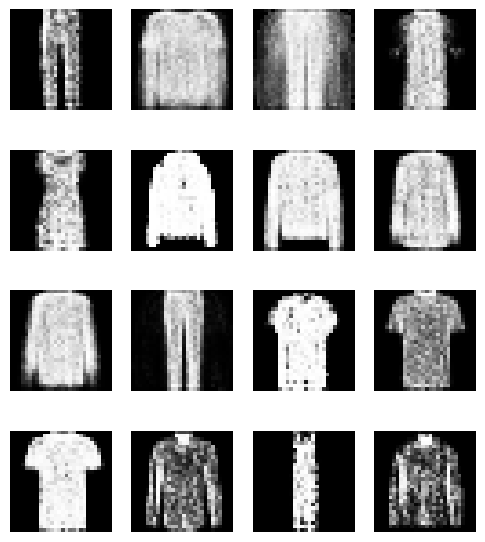

Training: 100%|██████████| 135000/135000 [34:55<00:00, 64.42it/s, epoch=36, errD=-.655, errG=-.126]


In [16]:
from tqdm import tqdm

config.num_epochs = 36

generator = Generator()
discriminator = Discriminator()

device = 'cuda' if torch.cuda.is_available() else 'cpu'
generator = generator.to(device)
discriminator = discriminator.to(device)

lr = 1e-4
betas = (.9, .99)
optim_D = optim.Adam(params=discriminator.parameters(), lr=lr,)
optim_G = optim.Adam(params=generator.parameters(), lr=lr,)

noise = Variable(torch.FloatTensor(config.batch_size, config.noise_size,).to(device))

errD = [list() for _ in range(config.num_epochs)]
errG = [list() for _ in range(config.num_epochs)]
N = len(dataloader)

# Создание объекта tqdm для отображения прогресса обучения
progress_bar = tqdm(total=config.num_epochs * N, desc='Training', position=0)

for epoch in range(config.num_epochs):
    # Вывод количества значений в одной эпохе
    print(f'Epoch {epoch+1} of {config.num_epochs}, {N} values per epoch')

    for iteration, (images, cat) in enumerate(dataloader):
        # Шаг градиентного подъема для критика
        discriminator.zero_grad()
        noise.data.normal_(0, 1)
        images = images.view(images.shape[0], -1).to(device)
        d_loss_real = discriminator(images).view(-1).mean(0)

        d_loss_fake = discriminator(generator(noise)).view(-1).mean(0)
        d_loss = -(d_loss_real - d_loss_fake)
        d_loss.backward()

        gradient_penalty = compute_gp(netD=discriminator, real_data=images, fake_data=generator(noise),)
        gradient_penalty.backward()

        errD[epoch].append(d_loss.item() + gradient_penalty.item())

        optim_D.step()

        # Шаг градиентного спуска для генератора
        if iteration % config.generator_freq == 0:
            generator.zero_grad()
            noise.data.normal_(0, 1)
            g_loss = -discriminator(generator(noise)).view(-1).mean(0)
            g_loss.backward()
            errG[epoch].append(g_loss.item())
            optim_G.step()

        # Обновление прогресса обучения
        progress_bar.update(1)
        progress_bar.set_postfix(epoch=epoch+1, errD=np.mean(errD[epoch]), errG=np.mean(errG[epoch]))

    # Генерация и вывод изображений после каждой эпохи
    noise.data.normal_(0, 1)
    fake = generator(noise)

    plt.figure(figsize=(6, 7))
    for i in range(config.batch_size):
        plt.subplot(4, 4, i + 1)
        plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)
        plt.axis('off')
    plt.show()

# Завершение отображения прогресса обучения
progress_bar.close()

## Визуализация ошибок обучения генератора и дискриминатора

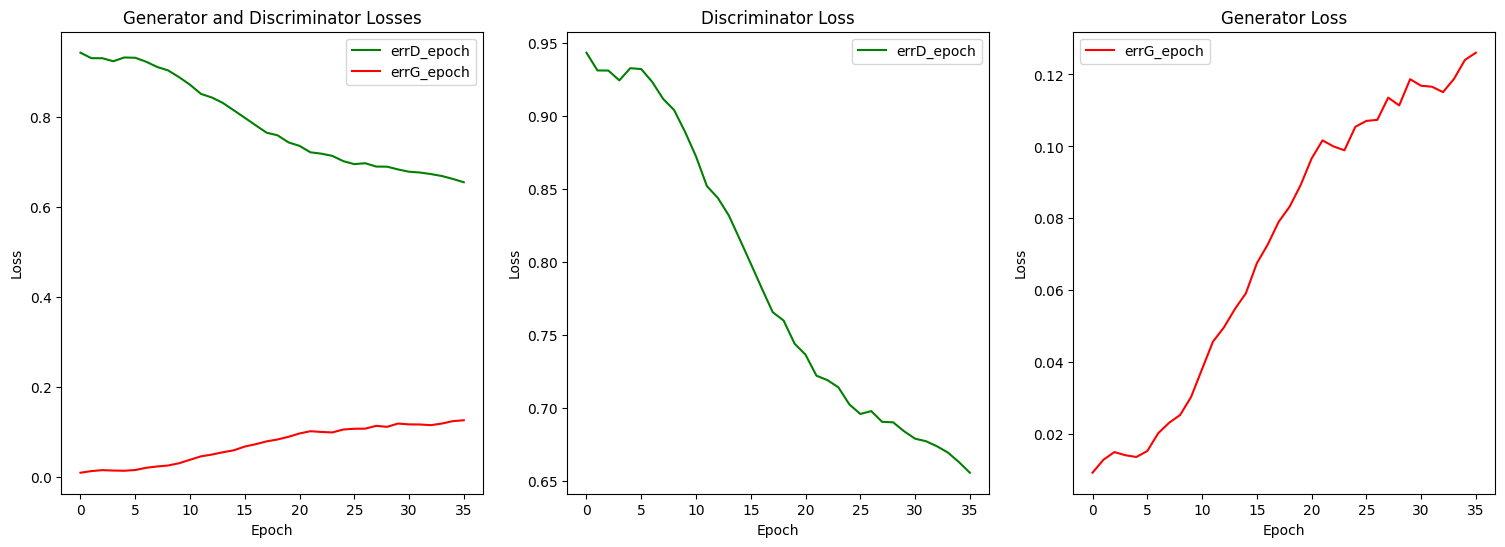

In [17]:
errD_epoch = -np.array(errD).mean(1)
errG_epoch = -np.array(errG).mean(1)

fig, ax = plt.subplots(1, 3, figsize=(18.5, 6))

# График ошибок генератора и дискриминатора
ax[0].plot(errD_epoch, color='green', label='errD_epoch')
ax[0].plot(errG_epoch, color='red', label='errG_epoch')
ax[0].set_title('Generator and Discriminator Losses')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Loss')
ax[0].legend()

# График ошибки дискриминатора
ax[1].plot(errD_epoch, color='green', label='errD_epoch')
ax[1].set_title('Discriminator Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend()

# График ошибки генератора
ax[2].plot(errG_epoch, color='red', label='errG_epoch')
ax[2].set_title('Generator Loss')
ax[2].set_xlabel('Epoch')
ax[2].set_ylabel('Loss')
ax[2].legend()

plt.show()

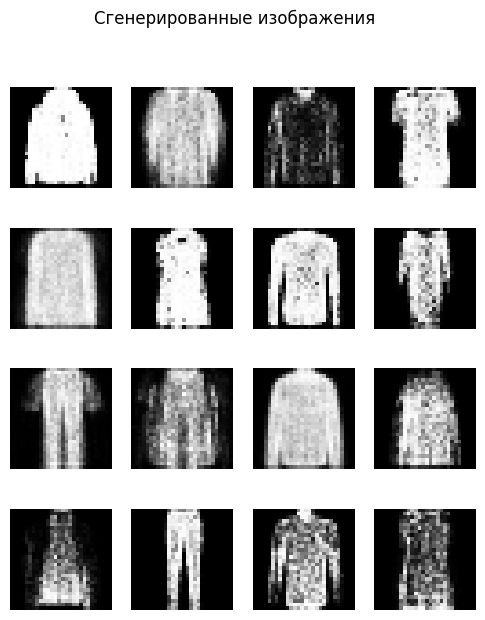

In [18]:
# Генерация шума
noise.data.normal_(0, 1)

# Генерация изображений с помощью генератора
fake = generator(noise)

# Создание фигуры для отображения изображений
plt.figure(figsize=(6, 7))

# Цикл по сгенерированным изображениям
for i in range(config.batch_size):
    # Создание подграфика для каждого изображения
    plt.subplot(4, 4, i + 1)

    # Отображение изображения
    plt.imshow(fake[i].detach().cpu().numpy().reshape(28, 28), cmap=plt.cm.Greys_r)

    # Удаление осей
    plt.axis('off')

plt.suptitle('Сгенерированные изображения')

plt.show()